# Quantum Neural Networks

## Overview
This notebook demonstrates different quantum neural network (QNN) implementations provided in `qiskit-machine-learning`, and how they can be integrated into basic quantum machine learning (QML) workflows.

The tutorial is structured as follows:
1. [Introduction](#Introduction)
2. [How to Instantiate QNNs](#Instantiate)
3. [How to Run a Forward Pass](#Forward)
4. [How to Run a Backward Pass](#Backward)
5. [Advanced Functionality](#Advanced)
6. [Conclusion](#Conclusion)

<a id='Introduction'></a>
## 1. Introduction

### 1.1. Quantum vs. Classical Neural Networks

Classical neural networks are algorithmic models inspired by the human brain that can be trained to recognize patterns in data and learn to solve complex problems. They are based in a series of interconnected nodes, or *neurons*, organized in a layered structure, with parameters that can be learned by applying machine or deep learning training strategies.

The motivation behind quantum machine learning (QML) is to integrate notions from quantum computing and classical machine learning to open the way for new and improved learning schemes. QNNs apply this generic principle by combining classical neural networks and parametrized quantum circuits. Because they lie at an intersection between two fields, QNNs can be viewed under two perspectives:

- From a **machine learning perspective**, QNNs are, once again, algorithmic models that can be trained to find hidden patterns in data in a similar manner to their classical counterparts (through backpropagation). These models are parametrized, and perform **data loading** with **input** parameters, and a **data processing** with trainable **weights**.

- From a **quantum computing perspective**, QNNs are quantum algorithms based on parametrized quantum circuits that can be trained in a variational manner using classical optimizers. These circuits contain a **feature map** (with input parameters) and an **ansatz** (with trainable weights).

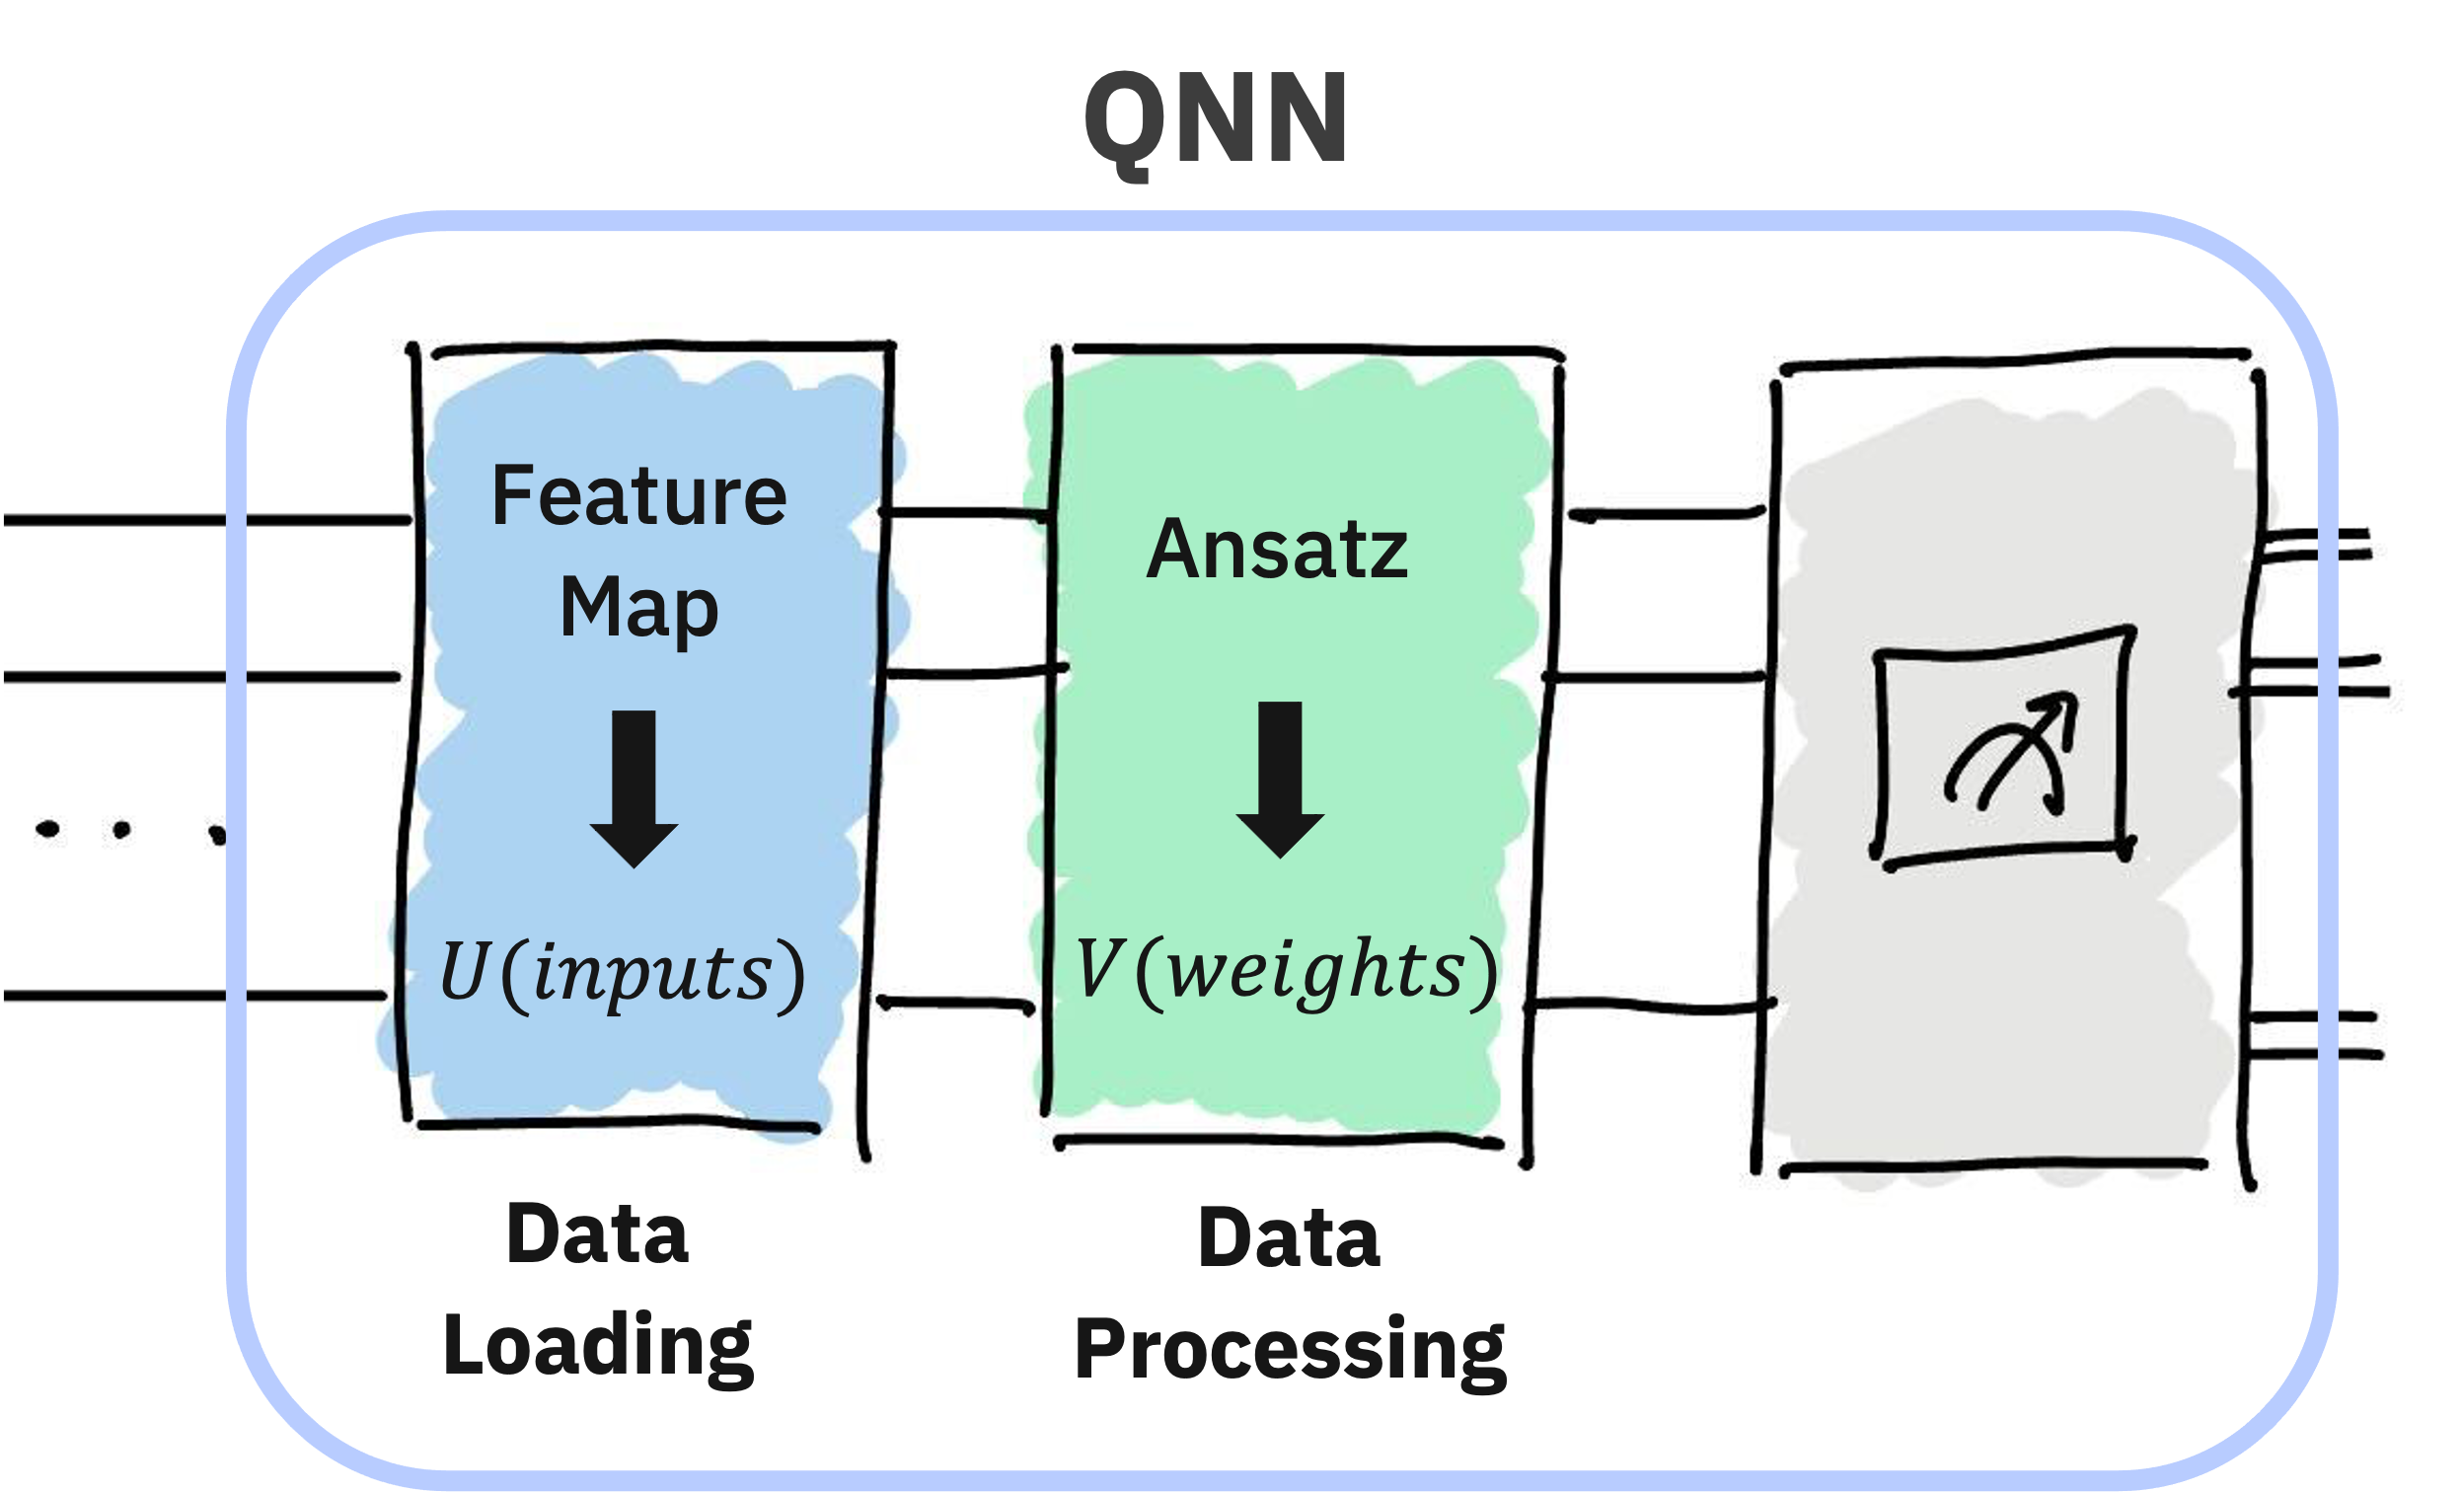

As you can see, these two perspectives are complementary, and do not necessarily rely on strict definitions of concepts such as "quantum neuron" or what constitutes a QNN's "layer".

### 1.2. Implementation in `qiskit-machine-learning`

The QNNs in `qiskit-machine-learning` are meant as application-agnostic computational units that can be used for different use cases, and their setup will depend on the application they are needed for. The module contains an interface of the QNNs and two specific implementations:

1. [NeuralNetwork](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.NeuralNetwork.html): The interface for neural networks. This is an abstract class all QNNs inherit from.
2. [EstimatorQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html): A network based on the evaluation of quantum mechanical observables.
3. [SamplerQNN](https://qiskit.org/documentation/machine-learning/locale/fr_FR/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html): A network based on the samples resulting from measuring a quantum circuit.

These implementations are based on the [qiskit primitives](https://qiskit.org/documentation/apidoc/primitives.html). The primitives are the entry point to run QNNs on either a simulator or real quantum hardware. Each implementation, `EstimatorQNN` and `SamplerQNN`, takes in an optional instance of their corresponding primitive, which can be any subclass of `BaseEstimator` and `BaseSampler` respectively.

The `qiskit.primitives` module provides a reference implementation for the `Sampler` and `Estimator` classes to run statevector simulations. By default, if no instance is passed to a QNN class, an instance of the corresponding reference primitive (`Sampler` or `Estimator`) is created automatically by the network.
For more information about primitives please refer to the [primitives documentation](https://qiskit.org/documentation/apidoc/primitives.html).

The `NeuralNetwork` class is the interface for all QNNs available in `qiskit-machine-learning`.
It exposes a forward and a backward pass that take data samples and trainable weights as input.

It's important to note that `NeuralNetwork`s are "stateless". They do not contain any training capabilities, these are pushed to the actual algorithms or applications ([classifiers](https://qiskit.org/documentation/machine-learning/apidocs/qiskit_machine_learning.algorithms.html#classifiers), [regressors](https://qiskit.org/documentation/machine-learning/apidocs/qiskit_machine_learning.algorithms.html#regressors), etc), nor do they store the values for trainable weights.

***

Let's now look into specific examples for the two `NeuralNetwork` implementations. But before, let's set up the algorithmic seed to ensure that the results don't change between runs.

In [1]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 42

<a id='Instantiate'></a>
## 2. How to Instantiate QNNs

### 2.1. `EstimatorQNN`

The `EstimatorQNN` takes in a parametrized quantum circuit as input, as well as an optional quantum mechanical observable, and outputs expectation value computations for the forward pass.

The quantum circuit's parameters can be used to load classical data (feature map) as well as represent trainable weights (ansatz). The observable allows to define custom loss functions for advanced QNN training strategies. The `EstimatorQNN` also accepts lists of observables to construct more complex QNNs.

Let's see an `EstimatorQNN` in action with a simple example. We start by constructing the parametrized circuit. This quantum circuit has two parameters, one represents a QNN input and the other represents a trainable weight:

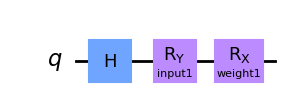

In [2]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

params1 = [Parameter("input1"), Parameter("weight1")]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc1.draw("mpl")

We can now create an observable to define the expectation value computation. If not set, then the `EstimatorQNN` will automatically create the default observable $Z^{\otimes n}$. Here, $n$ is the number of qubits of the quantum circuit.

In this example, we will change things up and use the $Y^{\otimes n}$ observable:

In [3]:
from qiskit.quantum_info import SparsePauliOp

observable1 = SparsePauliOp.from_list([("Y" * qc1.num_qubits, 1)])

Together with the quantum circuit defined above, and the observable we have created, the `EstimatorQNN` constructor takes in the following keyword arguments:

- `estimator`: optional primitive instance
- `input_params`: list of quantum circuit parameters that should be treated as "network inputs"
- `weight_params`: list of quantum circuit parameters that should be treated as "network weights"

In this example, we previously decided that the first parameter of `params1` should be the input, while the second should be the weight. We will not set the `estimator` parameter, the network will create an instance of the reference `Estimator` primitive for us.

In [4]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

estimator_qnn = EstimatorQNN(
    circuit=qc1, observables=observable1, input_params=[params1[0]], weight_params=[params1[1]]
)
estimator_qnn

Now, our QNN is ready to perform some backward and forward passes.

### 2.2. `SamplerQNN`

The `SamplerQNN` is instantiated in a similar way to the `EstimatorQNN`, but because it directly consumes samples from measuring the quantum circuit, it does not require a custom observable.

These output samples are interpreted by default as probabilities of measuring the integer index corresponding to a bitstring. However, the `SamplerQNN` also allows to specify an `interpret` function to post-process the samples. This function should be defined so that it takes a measured integer (from a bitstring) and map it to a new value, i.e. non-negative integer.

**(!)** It's important to note that if a custom `interpret` function is defined, the `output_shape` cannot be inferred by the network, and **needs to be provided explicitly**.

**(!)** It's also important to keep in mind that if no `interpret` function is used, the dimension of the probability vector will scale exponentially with the number of qubits. With a custom `interpret` function, this scaling can change. If, for instance, an index is mapped to the parity of the corresponding bitstring, i.e., to 0 or 1, the result will be a probability vector of length 2 independently of the number of qubits.

Let's have a look at `SamplerQNN` by first designing a simple quantum parameterized circuit using [RealAmplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html). `RealAmplitudes` consists of a quantum circuit with alternating layers of Y rotations and CX entanglements.

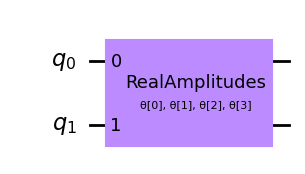

In [5]:
from qiskit.circuit.library import RealAmplitudes

qc2 = RealAmplitudes(2, entanglement="linear", reps=1)
qc2.draw(output="mpl")

This circuit contains four parameters, so we can assign the first three as inputs, and the last parameter as trainable weight, and give this information to the `SamplerQNN`:

In [24]:
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler_qnn = SamplerQNN(
    circuit=qc2, input_params=qc2.parameters[:3], weight_params=qc2.parameters[3:]
)
sampler_qnn

Please note that once again, we are choosing not to send the `Sampler` instance to the QNN and relying on the default.

<a id='Forward'></a>
## 3. How to Run a Forward Pass

In a real setting, the inputs would be defined by the dataset, and the weights would be defined by the training algorithm or as part of a pre-trained model. However, for the sake of this tutorial, we will specify random sets of input and weights of the right dimension:

In [7]:
# Estimator QNN Example
input_estimator = algorithm_globals.random.random(estimator_qnn.num_inputs)
weights_estimator = algorithm_globals.random.random(estimator_qnn.num_weights)

In [33]:
print(
    f"Number of input features for EstimatorQNN: {estimator_qnn.num_inputs} \nInput: {input_estimator}"
)
print(
    f"Number of trainable weights for EstimatorQNN: {estimator_qnn.num_weights} \nWeights: {weights_estimator}"
)

Number of input features for EstimatorQNN: 1 
Input: [0.77395605]
Number of trainable weights for EstimatorQNN: 1 
Weights: [0.43887844]


In [9]:
# Sampler QNN Example
input_sampler = algorithm_globals.random.random(sampler_qnn.num_inputs)
weights_sampler = algorithm_globals.random.random(sampler_qnn.num_weights)

In [34]:
print(f"Number of input features for SamplerQNN: {sampler_qnn.num_inputs} \nInput: {input_sampler}")
print(
    f"Number of trainable weights for SamplerQNN: {sampler_qnn.num_weights} \nWeights: {weights_sampler}"
)

Number of input features for SamplerQNN: 3 
Input: [0.85859792 0.69736803 0.09417735]
Number of trainable weights for SamplerQNN: 1 
Weights: [0.97562235]


Once we have the inputs and the weights, let's see the results for batched and non-batched passes.

### 3.1. Non-batched Forward Pass

For the `EstimatorQNN`, the expected output shape for the forward pass is `(1, num_qubits * num_observables)`:

In [11]:
forward_estimator = estimator_qnn.forward(input_estimator, weights_estimator)

print(f"Forward output shape for EstimatorQNN: {forward_estimator.shape}")

Forward output shape for EstimatorQNN: (1, 1)


For the `SamplerQNN` (without custom interpret function), the expected output shape for the forward pass is `(1, 2**num_qubits)`:

In [12]:
forward_sampler = sampler_qnn.forward(input_sampler, weights_sampler)

print(f"Forward output shape for SamplerQNN: {forward_sampler.shape}")

Forward output shape for SamplerQNN: (1, 4)


### 3.2. Batched Forward Pass

For the `EstimatorQNN`, the expected output shape for the forward pass is `(batch_size, num_qubits * num_observables)`:

In [13]:
forward_estimator_batched = estimator_qnn.forward(
    [input_estimator, input_estimator], weights_estimator
)

print(f"Forward output shape for EstimatorQNN: {forward_estimator_batched.shape}")

Forward output shape for EstimatorQNN: (2, 1)


For the `SamplerQNN` (without custom interpret function), the expected output shape for the forward pass is `(batch_size, 2**num_qubits)`:

In [14]:
forward_sampler_batched = sampler_qnn.forward([input_sampler, input_sampler], weights_sampler)

print(f"Forward output shape for SamplerQNN: {forward_sampler_batched.shape}")

Forward output shape for SamplerQNN: (2, 4)


<a id='Backward'></a>
## 4. How to Run a Backward Pass

Let's take advantage of the inputs and weights defined above to show how the backward pass works. This pass returns a tuple `(input_gradients, weight_gradients)`. By default, the backward pass will only calculate gradients with respect to the weight parameters. If you want to enable gradients with respect to the input parameters, you should set the following flag during the QNN instantiation:

```python
qnn = ...QNN(..., input_gradients=True)
```

### 4.1. Backward Pass without Input Gradients

For the `EstimatorQNN`, the expected output shape for the weight gradients is: `(batch_size, num_qubits * num_observables, num_weights)`:

In [15]:
input_grad_e, weight_grad_e = estimator_qnn.backward(input_estimator, weights_estimator)

print(f"Input gradients shape for EstimatorQNN: {input_grad_e}")
print(f"Weight gradients shape for EstimatorQNN: {weight_grad_e.shape}")

Input gradients shape for EstimatorQNN: None
Weight gradients shape for EstimatorQNN: (1, 1, 1)


For the `SamplerQNN` (without custom interpret function), the expected output shape for the forward pass is `(batch_size, 2**num_qubits, num_weights)`:

In [16]:
input_grad_s, weight_grad_s = sampler_qnn.backward(input_sampler, weights_sampler)

print(f"Input gradients shape for SamplerQNN: {input_grad_s}")
print(f"Weight gradients shape for SamplerQNN: {weight_grad_s.shape}")

Input gradients shape for SamplerQNN: None
Weight gradients shape for SamplerQNN: (1, 4, 1)


### 4.2. Backward Pass with Input Gradients

Let's enable the `input_gradients` to show what the expected output sizes are for this option.

In [17]:
estimator_qnn.input_gradients = True
sampler_qnn.input_gradients = True

For the `EstimatorQNN`, the expected output shape for the input gradients is: `(batch_size, num_qubits * num_observables, num_inputs)`:

In [18]:
input_grad_e, weight_grad_e = estimator_qnn.backward(input_estimator, weights_estimator)

print(f"Input gradients shape for EstimatorQNN: {input_grad_e.shape}")

Input gradients shape for EstimatorQNN: (1, 1, 1)


For the `SamplerQNN` (without custom interpret function), the expected output shape for the forward pass is `(batch_size, 2**num_qubits, num_inputs)`:

In [19]:
input_grad_s, weight_grad_s = sampler_qnn.backward(input_sampler, weights_sampler)

print(f"Input gradients shape for SamplerQNN: {input_grad_s.shape}")

Input gradients shape for SamplerQNN: (1, 4, 3)


<a id='Advanced'></a>
## 5. Advanced Functionality

### 5.1. `EstimatorQNN` with Multiple Observables

The `EstimatorQNN` allows to pass lists of observables for more complex QNN architectures. For example (note the change in output shape):

In [20]:
observable2 = SparsePauliOp.from_list([("Z" * qc1.num_qubits, 1)])

estimator_qnn2 = EstimatorQNN(
    circuit=qc1,
    observables=[observable1, observable2],
    input_params=[params1[0]],
    weight_params=[params1[1]],
)

In [21]:
forward_estimator2 = estimator_qnn2.forward(input_estimator, weights_estimator)
input_grad_e2, weight_grad_e2 = estimator_qnn2.backward(input_estimator, weights_estimator)

print(f"Forward output for EstimatorQNN1: {forward_estimator.shape}")
print(f"Forward output for EstimatorQNN2: {forward_estimator2.shape}")
print(f"Backward output for EstimatorQNN1: {weight_grad_e.shape}")
print(f"Backward output for EstimatorQNN2: {weight_grad_e2.shape}")

Forward output for EstimatorQNN1: (1, 1)
Forward output for EstimatorQNN2: (1, 2)
Backward output for EstimatorQNN1: (1, 1, 1)
Backward output for EstimatorQNN2: (1, 2, 1)


### 5.2. `SamplerQNN` with custom `interpret`

One common `interpret` method for `SamplerQNN` is the `parity` function, that allows to perform binary classification. As explained in the instantiation section, the use of interpret functions will modify the output shape of the forward and backward passes (`output_shape` instead of `2**num_qubits`).

In [25]:
parity = lambda x: "{:b}".format(x).count("1") % 2
output_shape = 2  # parity = 0, 1

sampler_qnn2 = SamplerQNN(
    circuit=qc2,
    input_params=qc2.parameters[:3],
    weight_params=qc2.parameters[3:],
    interpret=parity,
    output_shape=output_shape,
)

In [26]:
forward_sampler2 = sampler_qnn2.forward(input_sampler, weights_sampler)
input_grad_s2, weight_grad_s2 = sampler_qnn2.backward(input_sampler, weights_sampler)

print(f"Forward output for SamplerQNN1: {forward_sampler.shape}")
print(f"Forward output for SamplerQNN2: {forward_sampler2.shape}")
print(f"Backward output for SamplerQNN1: {weight_grad_s.shape}")
print(f"Backward output for SamplerQNN2: {weight_grad_s2.shape}")

Forward output for SamplerQNN1: (1, 4)
Forward output for SamplerQNN2: (1, 2)
Backward output for SamplerQNN1: (1, 4, 1)
Backward output for SamplerQNN2: (1, 2, 1)


<a id='Conclusion'></a>
## 6. Conclusion
In this tutorial, we learn about the two neural networks provided by Qiskit Machine Learning, namely `EstimatorQNN` and `SamplerQNN`, which extend the base `NeuralNetwork` class.

TODO

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright